In [1]:
import numpy as np
import pandas as pd

In [2]:
turb_data=pd.read_csv('../../turb_data.csv')
turb_data

,x_coord,y_coord,ref_wind_speed,wind_speed,turb_num,num_tot_turb,ID,IDnum
0,0.000000,0.000000,2.990576,4,0,2,2_turbine_248.0_degrees_558_meters,0
1,517.368591,209.030479,2.980920,4,1,2,2_turbine_248.0_degrees_558_meters,0
2,0.000000,0.000000,2.983835,4,0,2,2_turbine_269.0_degrees_279_meters,1
3,278.957507,4.869221,2.713630,4,1,2,2_turbine_269.0_degrees_279_meters,1
4,0.000000,0.000000,2.994947,4,0,2,2_turbine_289.0_degrees_558_meters,2
...,...,...,...,...,...,...,...,...
8819,670.079580,58.000000,14.692290,16,1,3,3_turbine_65th_simulation,3870
8820,2666.020316,-73.000000,14.800027,16,2,3,3_turbine_65th_simulation,3870
8821,0.000000,0.000000,14.935284,16,0,3,3_turbine_71th_simulation,3871
8822,645.525102,-37.000000,14.411438,16,1,3,3_turbine_71th_simulation,3871


In [3]:
dataset=turb_data.drop(['ID','turb_num'], axis=1)

In [4]:
dataset

,x_coord,y_coord,ref_wind_speed,wind_speed,num_tot_turb,IDnum
0,0.000000,0.000000,2.990576,4,2,0
1,517.368591,209.030479,2.980920,4,2,0
2,0.000000,0.000000,2.983835,4,2,1
3,278.957507,4.869221,2.713630,4,2,1
4,0.000000,0.000000,2.994947,4,2,2
...,...,...,...,...,...,...
8819,670.079580,58.000000,14.692290,16,3,3870
8820,2666.020316,-73.000000,14.800027,16,3,3870
8821,0.000000,0.000000,14.935284,16,3,3871
8822,645.525102,-37.000000,14.411438,16,3,3871


In [5]:
import os
os.chdir("../..")
import descriptor.three_desc_model as desc
from descriptor.cutoffs import Polynomial
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
symbol="Siemens"
turb = [symbol]
numsims=dataset["IDnum"].iloc[-1]+1

In [6]:
nl=desc.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377}
                 ]}
finpr=desc.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_rws=np.empty(shape=(0, 1))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset["num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    rws = np.empty((numturb,1))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset["x_coord"].iloc[count]#dataset_full.at[count,"x_coord"]
        position[k,1]=dataset["y_coord"].iloc[count]#dataset_full.at[count,"y_coord"]
        rws[k,0]=dataset["ref_wind_speed"].iloc[count]#dataset_full.at[count,"ref_wind_speed"]
        ws[k,0]=dataset["wind_speed"].iloc[count]#dataset_full.at[count,"wind_speed"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_rws=np.append(dataset_rws,rws,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
all_data=np.concatenate((dataset_fp, dataset_ws, dataset_rws),axis=1)
#all_data=np.concatenate((dataset_fp, dataset_rws),axis=1)
all_data = pd.DataFrame(all_data, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Wind_Speed','Ref_Wind_Speed'])
#all_data = pd.DataFrame(all_data, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=all_data[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)","Wind_Speed"]].to_numpy()
#X=all_data[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=all_data[["Ref_Wind_Speed"]].to_numpy()
train_dataset = all_data.sample(frac=0.8, random_state=0)
test_dataset = all_data.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)","Wind_Speed"]].to_numpy()
#Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)","Wind_Speed"]].to_numpy()
#Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

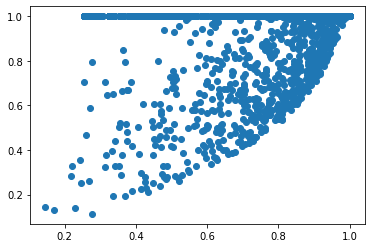

In [27]:
plt.scatter(Xtrain[:,0],Xtrain[:,2])

In [9]:
# define kernel
ker = GPy.kern.RBF(4,lengthscale=0.1, ARD=True)# + GPy.kern.White(2)

In [11]:
# create simple GP model
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [12]:
# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
#fig = m.plot()
#display(GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d'))
display(m)

GP_regression.,value,constraints,priors
rbf.variance,46.59600695404575,+ve,
rbf.lengthscale,"(4,)",+ve,
Gaussian_noise.variance,0.00487395599200202,+ve,


In [13]:
print(m)


Name : GP regression
Objective : -8138.7048788921
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    46.59600695404575  |      +ve      |        
  rbf.lengthscale          |                 (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00487395599200202  |      +ve      |        


In [14]:
[Ypred,Yvar]=m.predict(Xtest)
error_test=np.abs(Ypred-Ytest)
np.max(error_test)

0.47178679941464985

In [15]:
[Yval,Yvalvar]=m.predict(Xtrain)
error_train=np.abs(Yval-Ytrain)
np.max(error_train)

0.40661354630973534

In [16]:
[Yall,Yallvar]=m.predict(X)
error_all=np.abs(Yall-Y)
np.max(error_all)

0.47178679941464985

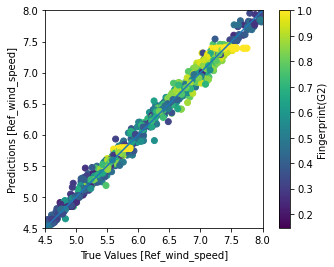

In [18]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,0])     #"Fingerprint(G2)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,0])  #"Fingerprint(G2)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G2)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [17]:
position=np.array([[0,0],[500,0]])
neigh=nl.calculate(turb*2,position)
#print(neigh)
fingerprints=np.array(finpr.calculate(turb*2,position,neigh,symbol))
test_data=np.append(fingerprints,[[10],[10]],axis=1)
#print(test_data)
m.predict(test_data)

(array([[7.2399118 ],
        [6.55191403]]),
 array([[0.2027828 ],
        [0.21782602]]))

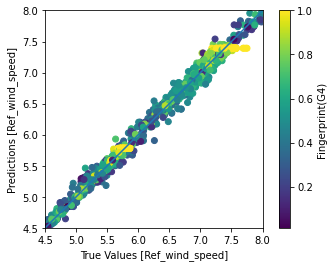

In [19]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,1])     #"Fingerprint(G4)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,1])  #"Fingerprint(G4)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

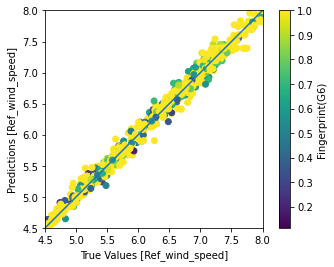

In [20]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G6)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G6)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G6)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

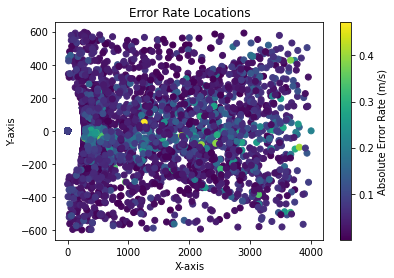

In [21]:
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

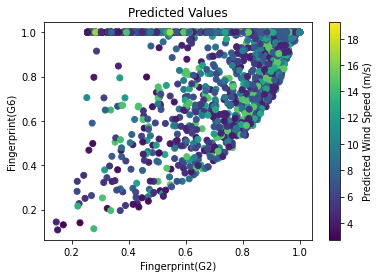

In [28]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

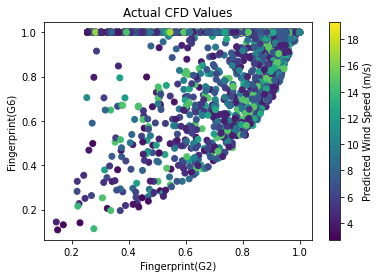

In [29]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

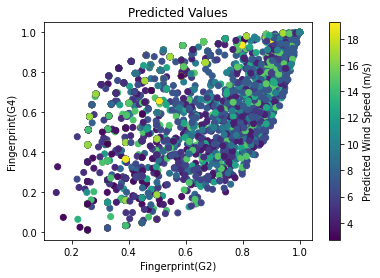

In [22]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

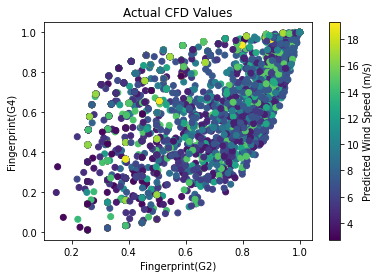

In [23]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

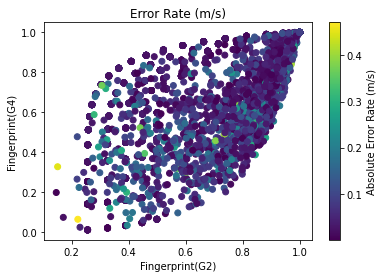

In [24]:
a = plt.axes
plt.scatter(X[:,0], X[:,1],c=error_all)
#plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate (m/s)')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

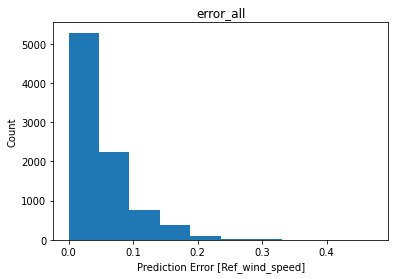

In [25]:
plt.hist(error_all, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_all')
_ = plt.ylabel('Count')

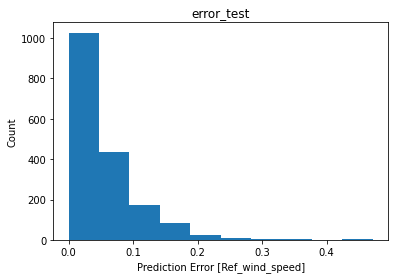

In [26]:
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_test')
_ = plt.ylabel('Count')